# 导入包

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose,Reshape

/home/vip/anaconda3/envs/shy2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.__version__

'1.13.1'

# 试验参数的赋值

In [25]:
%matplotlib inline
batch_size = 256
original_dim = 784
latent_dim = 8
epochs = 3
epsilon_std = 1.0 #用于重参数
noise_factor = 0.5

# 导入数据集

In [4]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 数据信息

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
x_test.shape

(10000, 28, 28)

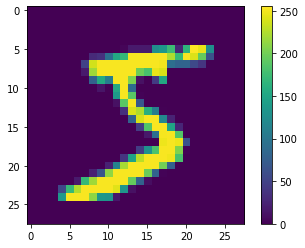

In [7]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
#数据预处理

将这些值缩小至 0 到 1 之间，除以 255。
然后将数据进行reshape

最后加入高斯噪声生成噪声数据，然后将其馈送到神经网络模型。
以相同的方式对训练集和测试集进行预处理：

In [9]:
train_num=50000
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28,28,1))
x_test = x_test.reshape((len(x_test), 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.)
noise_test = np.clip(noise_test, 0., 1.)

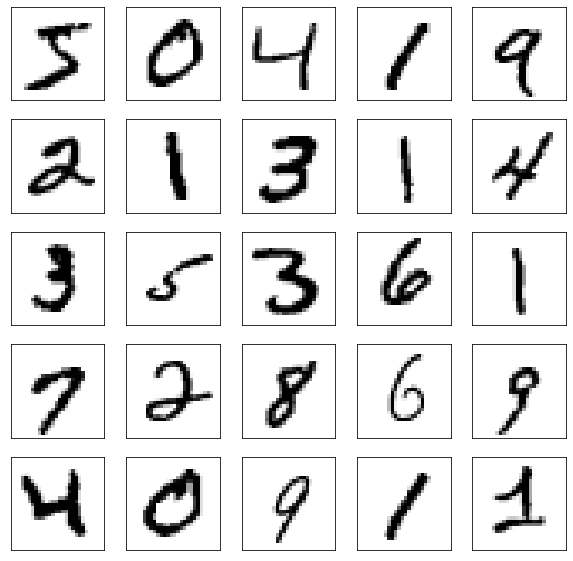

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    #plt.imshow(train_images[i])
    #plt.colorbar()
    #print(train_labels[1])
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

加入随机高斯噪声后的数据展示

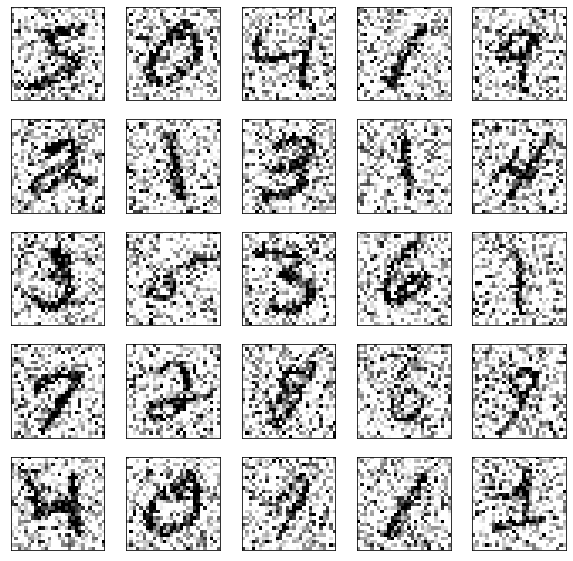

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noise_train[i], cmap=plt.cm.binary)
    #plt.imshow(train_images[i])
    #plt.colorbar()
    #print(train_labels[1])
#     plt.xlabel(class_names[train_labels[i][0]])
plt.show()

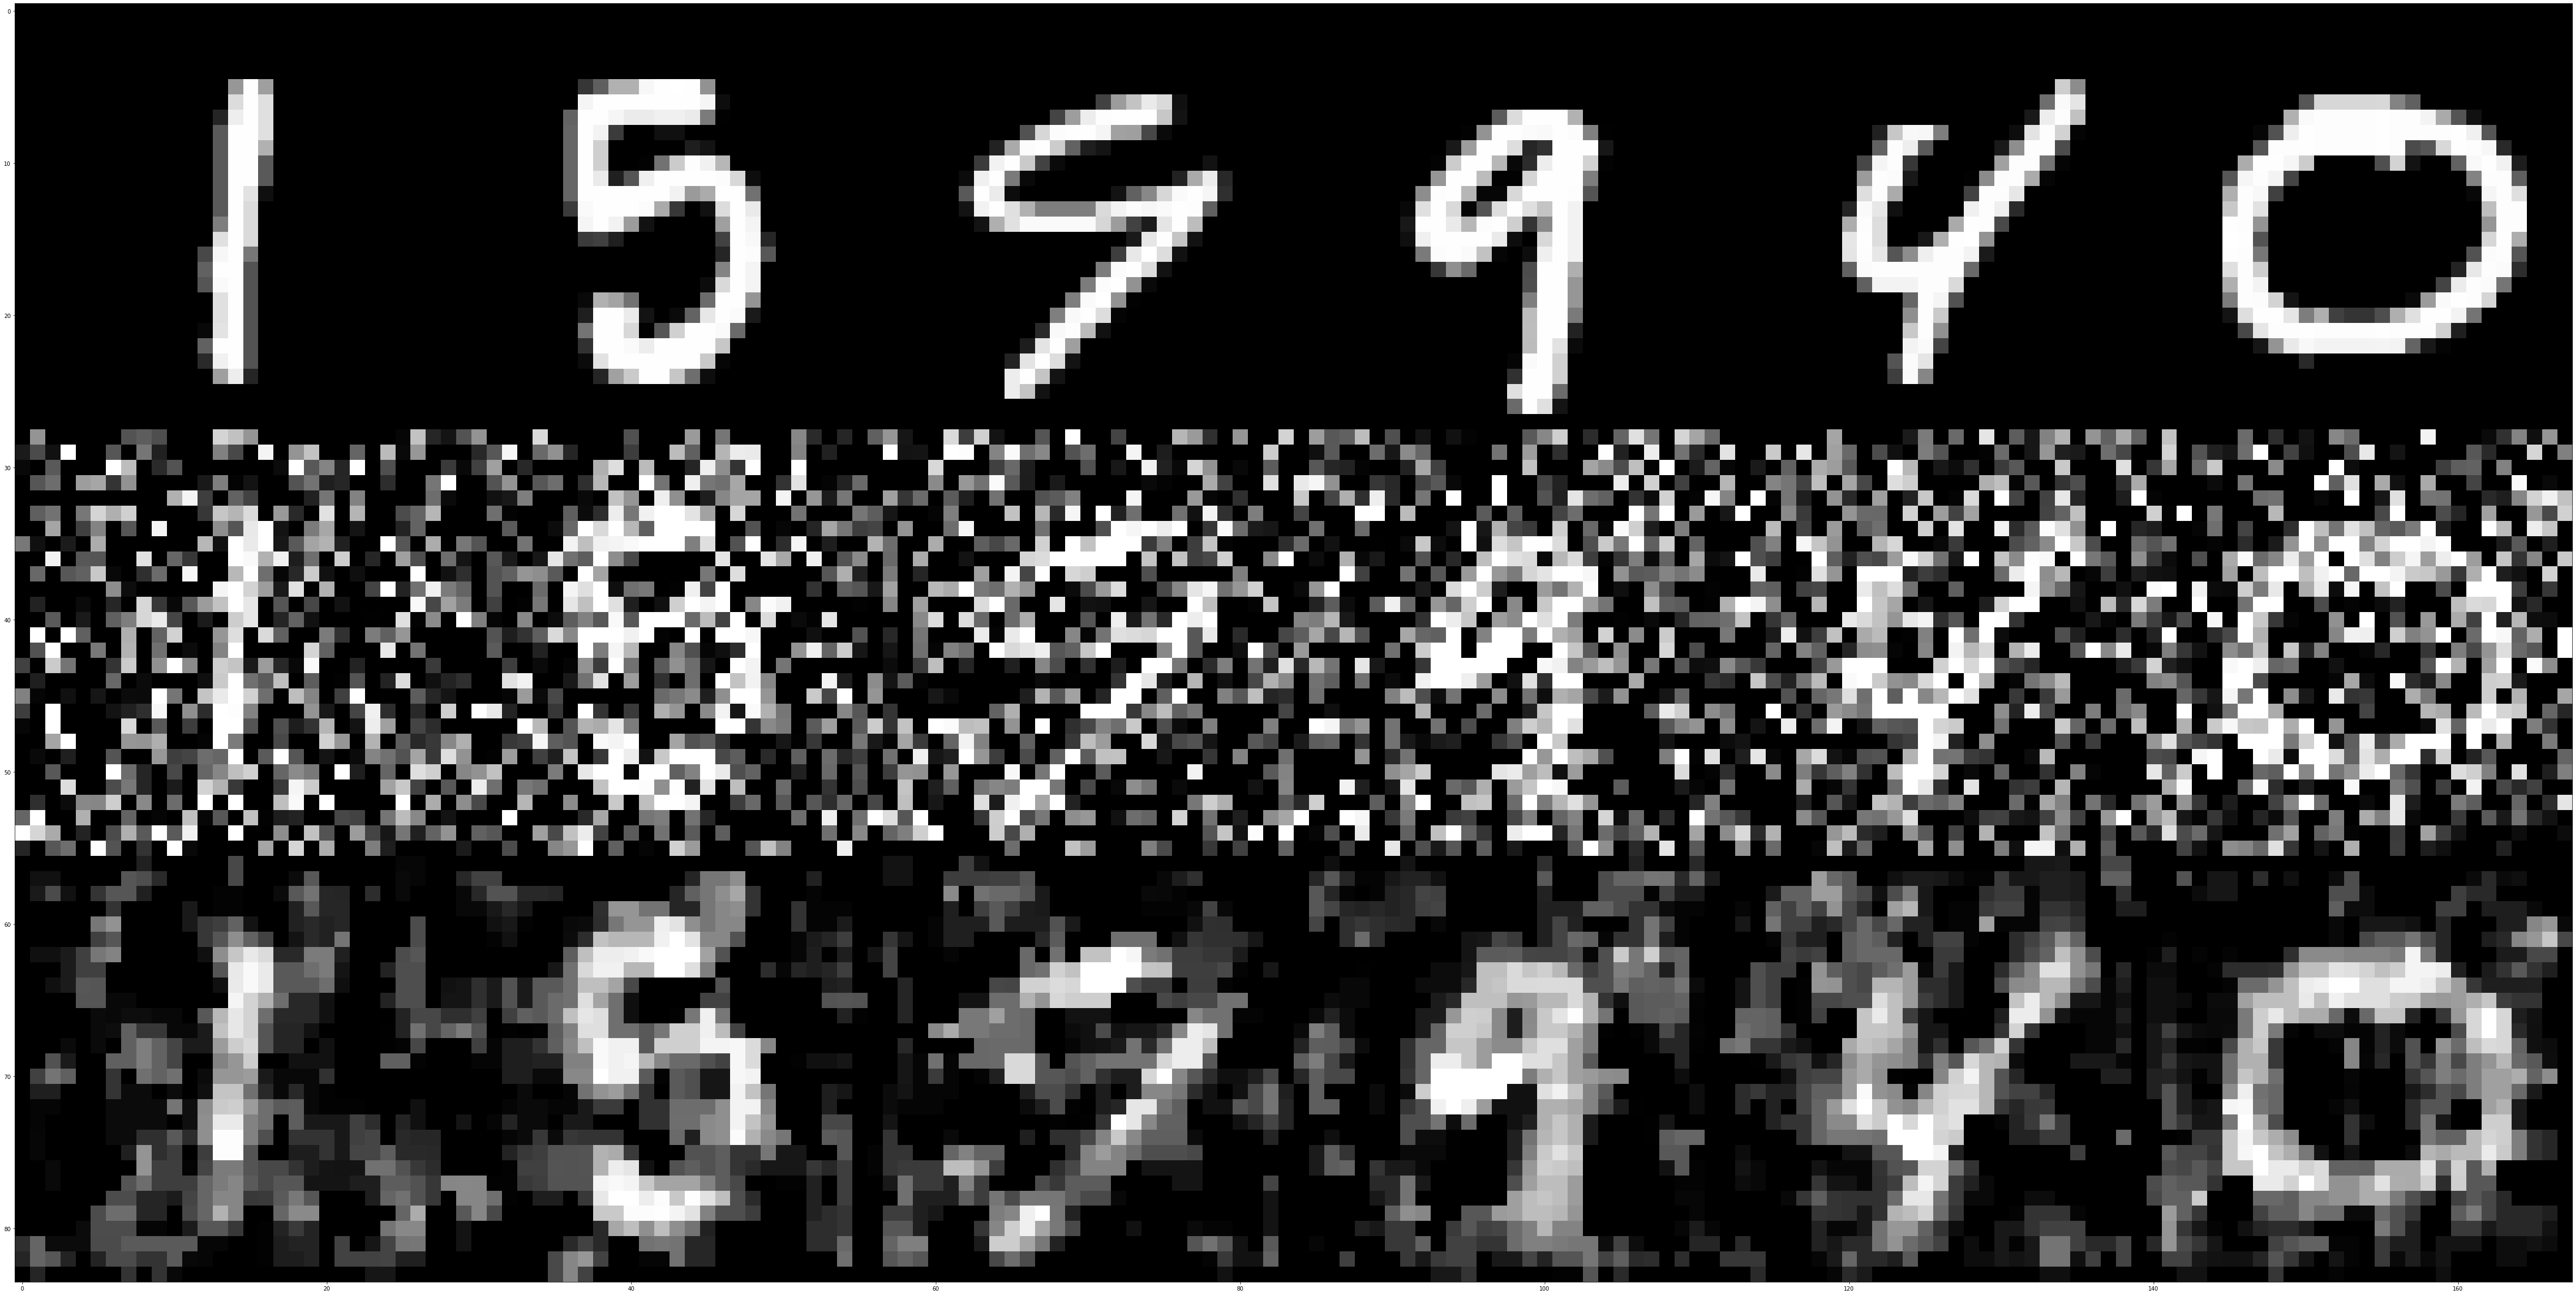

In [12]:
num_train = 50000
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# 模型构建

编码器模型

In [28]:
#encoder part
x_noise = Input(shape=(28,28,1))
conv_1 = Conv2D(64,(3, 3), padding='valid',activation='relu')(x_noise)
conv_2 = Conv2D(64,(3, 3), padding='valid',activation='relu')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_2)
conv_3 = Conv2D(32,(3, 3), padding='valid',activation='relu')(pool_1)
pool_2 = MaxPooling2D((2, 2))(conv_3)
h=Flatten()(pool_2)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#reparameterization trick
#重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

解码器模型

In [29]:
#decoder part
# we instantiate these layers xc separately so as to reuse them later
z=Reshape([1,1,latent_dim])(z)
conv_0T = Conv2DTranspose(128,(1, 1), padding='valid',activation='relu')(z)#1*1
conv_1T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_0T)#3*3
conv_2T = Conv2DTranspose(64,(3, 3), padding='valid',activation='relu')(conv_1T)#5*5
conv_3T = Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_2T)#10*10
conv_4T = Conv2DTranspose(48,(3, 3), padding='valid',activation='relu')(conv_3T)#12*12
conv_5T = Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation='relu')(conv_4T)#24*24
conv_6T = Conv2DTranspose(16,(3, 3), padding='valid',activation='relu')(conv_5T)#26*26
x_out = Conv2DTranspose(1,(3, 3), padding='valid',activation='sigmoid')(conv_6T)#28*28

# instantiate VAE model
vae = Model(x_noise, x_out)

变分自编码器总模型及参数

In [30]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 26, 26, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 24, 24, 64)   36928       conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 12, 12, 64)   0           conv2d_5[0][0]                   
____________________________________________________________________________________________

模型结构图

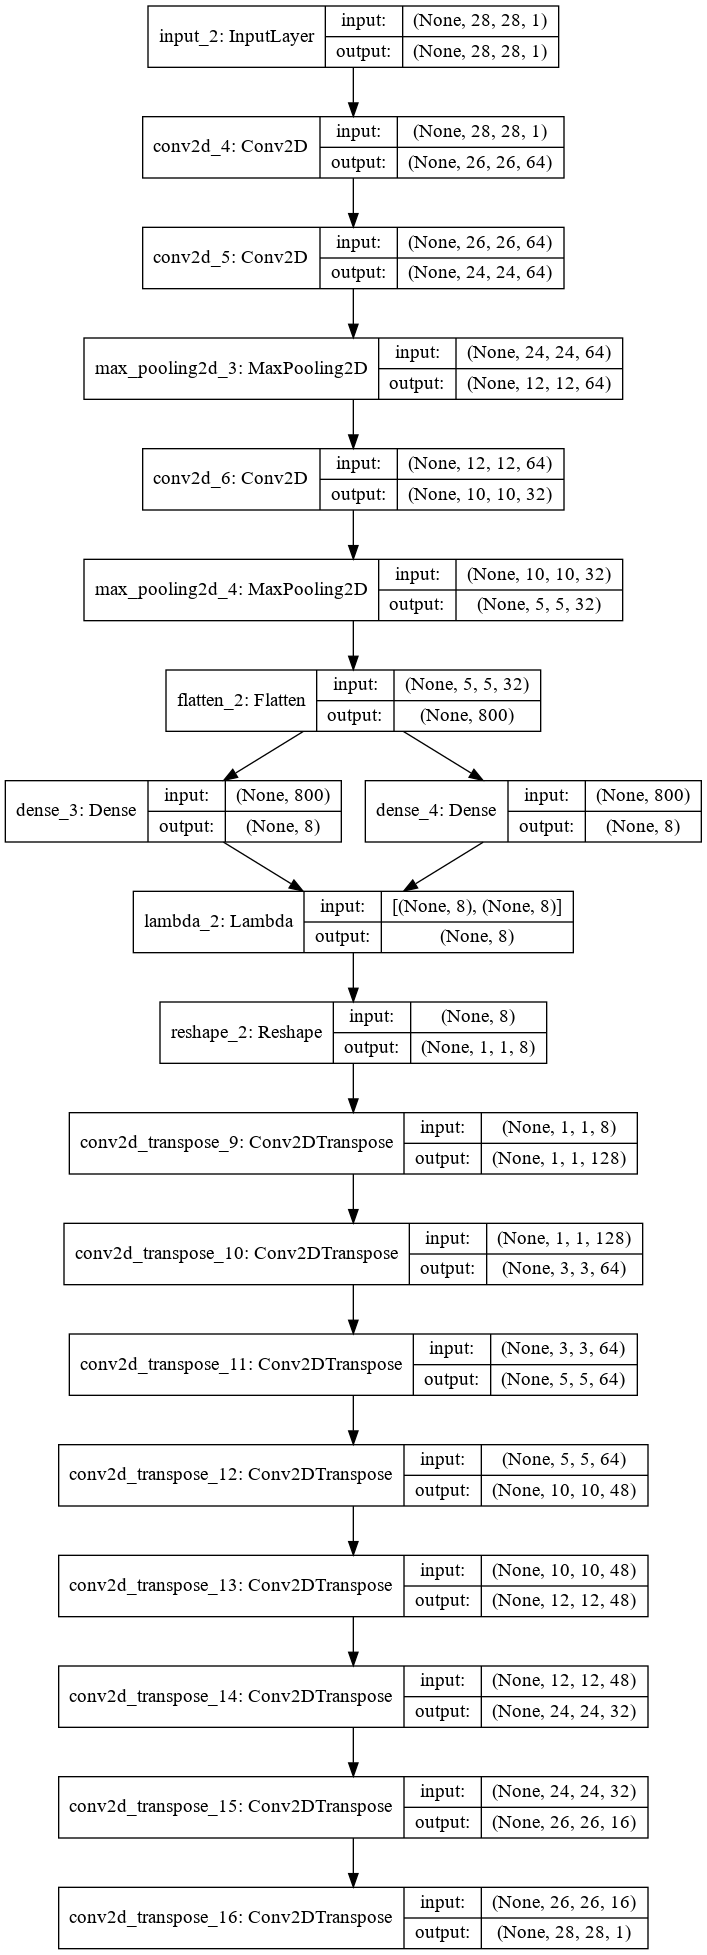

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(vae, to_file='model1.png',show_shapes=True)

# 变分自编码器损失函数

In [32]:
# Compute VAE loss
def VAE_loss(x_origin,x_out):
    x_origin=K.flatten(x_origin)
    x_out=K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 - K.square(z_mean) + z_log_var - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

编译模型

In [33]:
vae.compile(optimizer='adam', loss=VAE_loss)

# 训练模型

In [63]:
history = vae.fit(noise_train,x_train,
          shuffle=True,
          epochs=20,
          batch_size=batch_size,
          validation_data=(noise_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 105s 2ms/step - loss: 231.0530 - val_loss: 172.4401
Epoch 2/20
60000/60000 [==============================] - 102s 2ms/step - loss: 146.2598 - val_loss: 134.5228
Epoch 3/20
60000/60000 [==============================] - 99s 2ms/step - loss: 132.1728 - val_loss: 130.0610
Epoch 4/20
60000/60000 [==============================] - 98s 2ms/step - loss: 128.0485 - val_loss: 125.8624
Epoch 5/20
60000/60000 [==============================] - 98s 2ms/step - loss: 125.8324 - val_loss: 124.1350
Epoch 6/20
60000/60000 [==============================] - 98s 2ms/step - loss: 124.2803 - val_loss: 122.7243
Epoch 7/20
60000/60000 [==============================] - 100s 2ms/step - loss: 123.2455 - val_loss: 121.9377
Epoch 8/20
60000/60000 [==============================] - 98s 2ms/step - loss: 122.4819 - val_loss: 121.2013
Epoch 9/20
60000/60000 [==============================] - 98s 2ms/step - lo

损失可视化

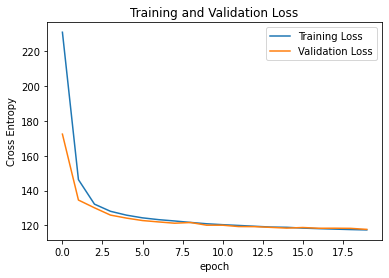

In [64]:

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


保存模型和history

In [65]:
#保存模型权重
#保存训练细节
vae.save('vae.h5')

# #保存history
# import pickle
# with open('result_test.pickle', 'wb') as file_pi:
# 	pickle.dump(history.history, file_pi)

加载模型和history

In [75]:
# # 加载模型权重
# # 加载训练细节

# from tensorflow import keras
# #vae = keras.models.load_model('vae.h5')
# vae = keras.models.load_model("vae.h5")
# # import pickle
# # with open('model_vi_bs_128_lrdefault_hist.pickle', 'rb') as f:
# #     history = pickle.load(f)


# 测试

In [66]:
digit_size = 28
figure = np.zeros((digit_size * 4, digit_size * n_images))

0 6574
1 5149
2 5732
3 1062
4 431
5 6102


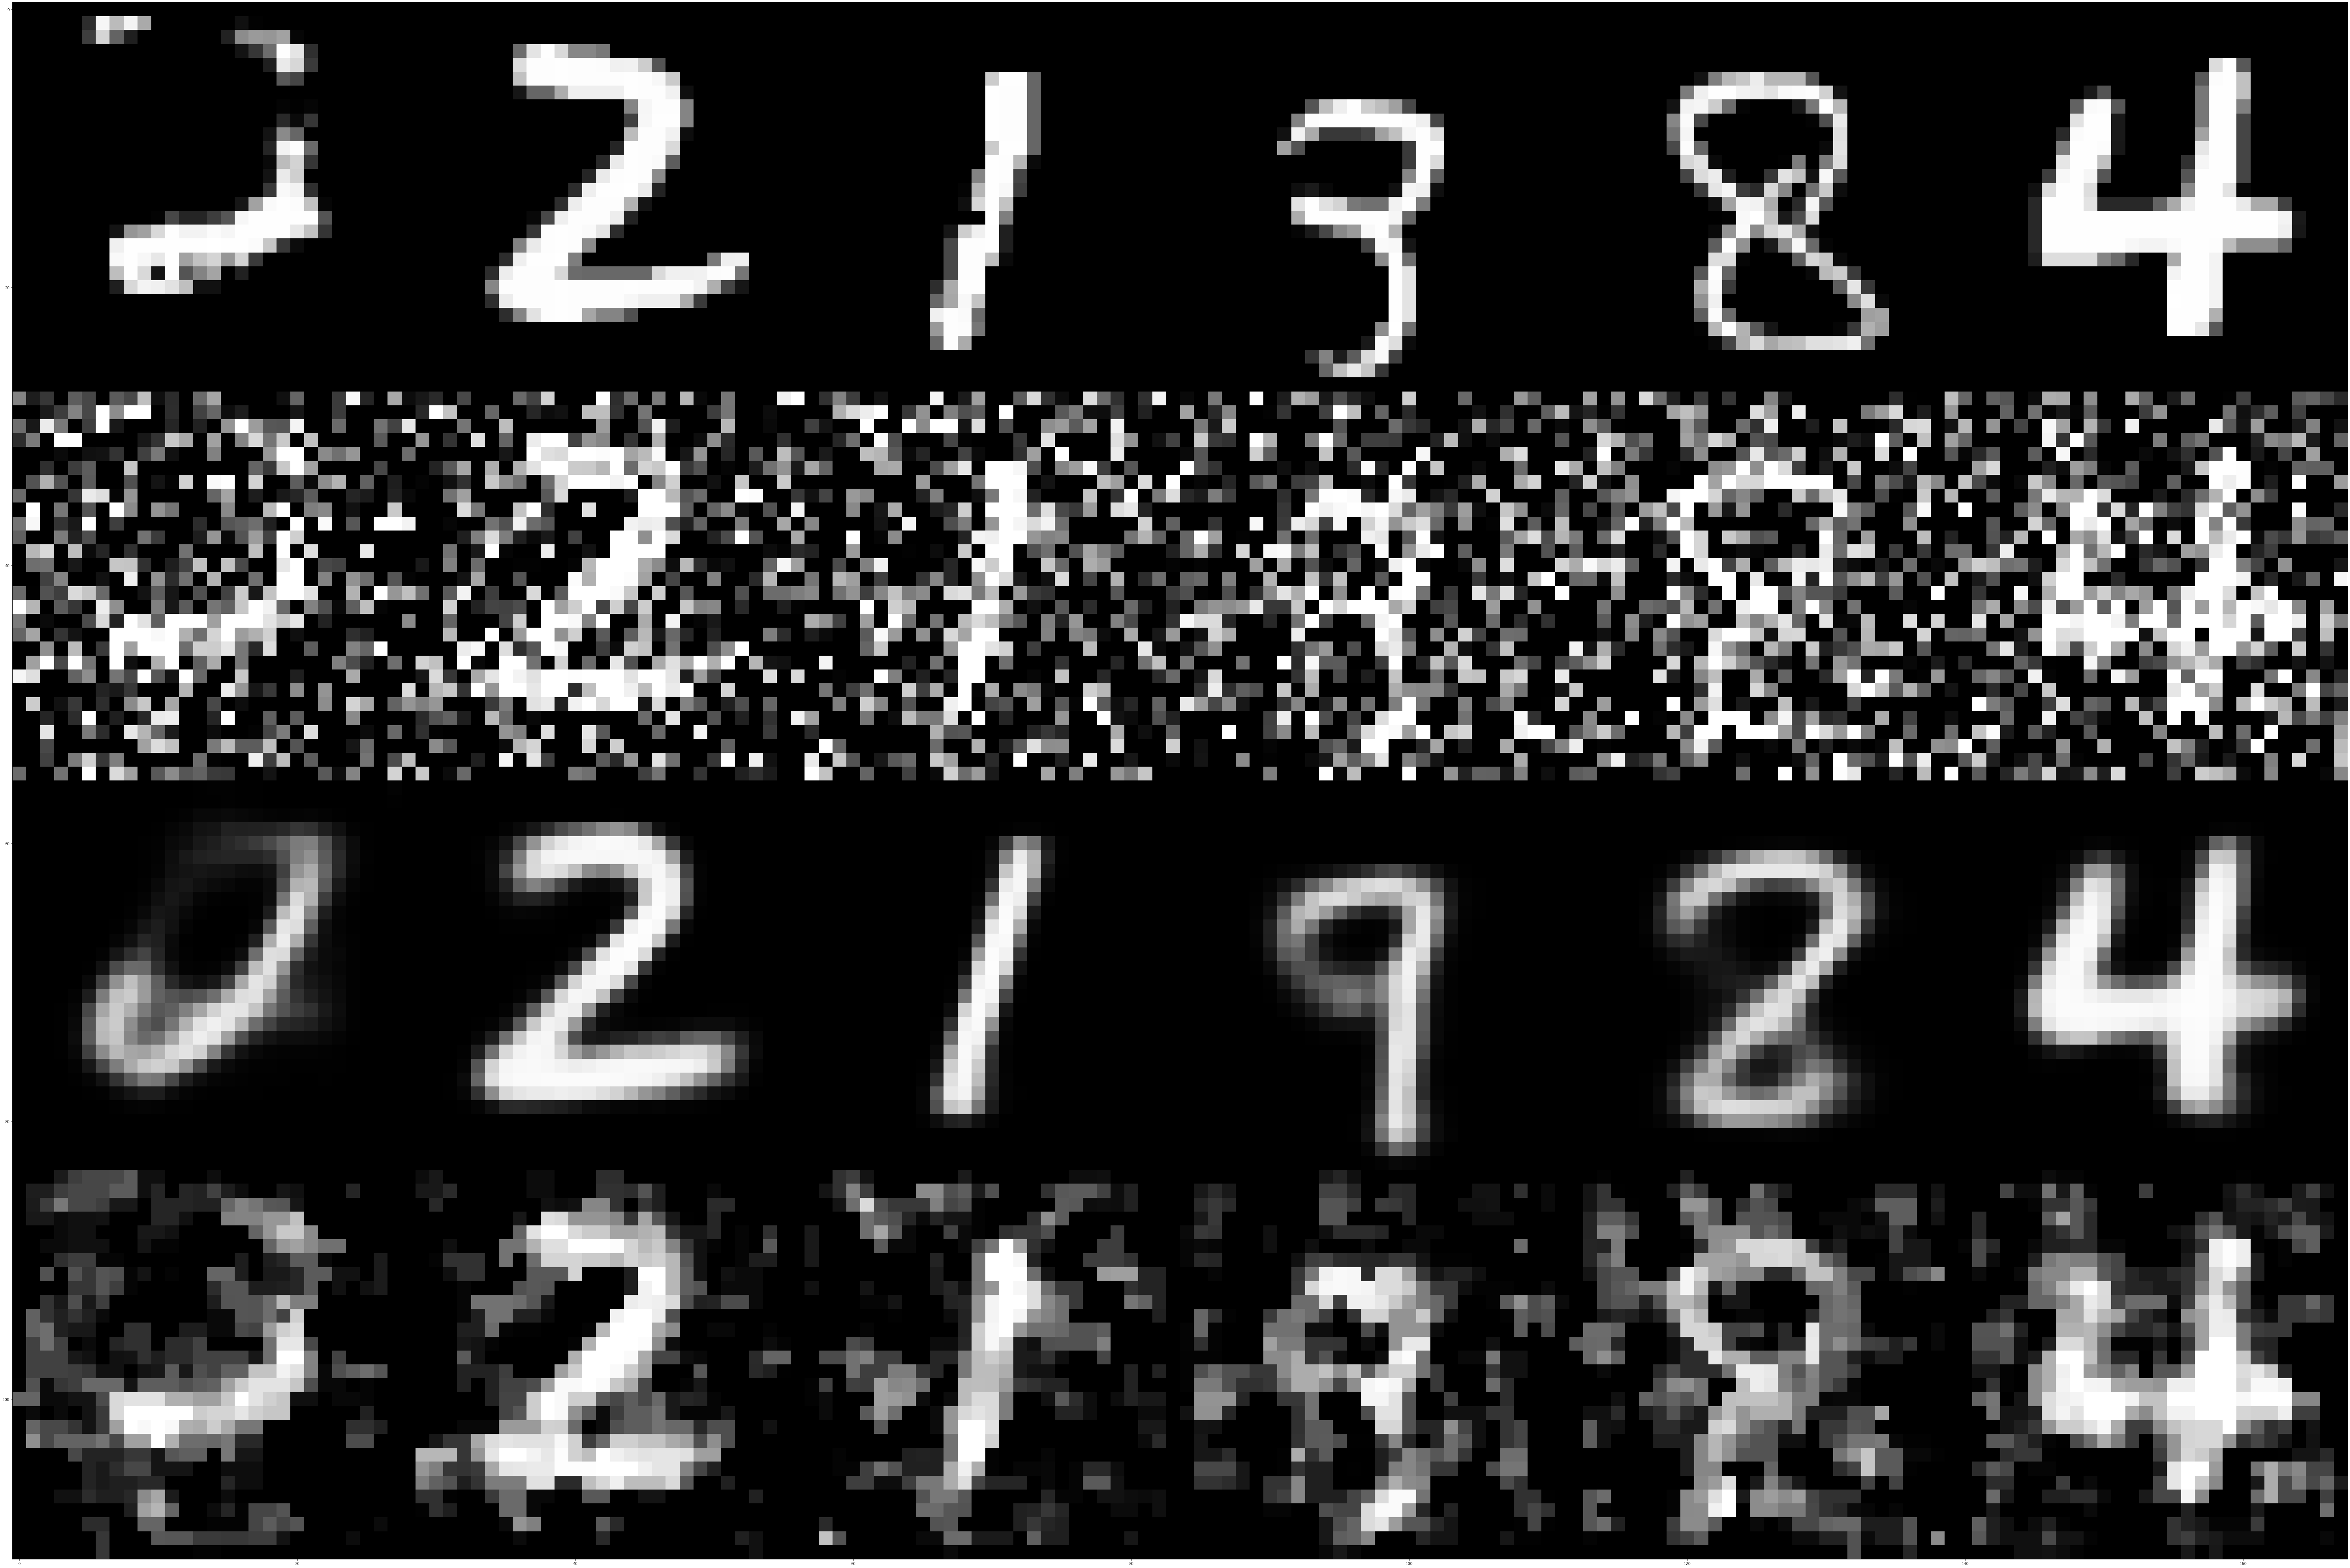

In [67]:
num_test=10000
showidx=np.random.randint(0,num_test,n_images)
x_out=vae.predict(noise_test[showidx])
# Display
for i,idx in enumerate (showidx):
    print(i,idx)
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(x_out[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_keras_VAE.png')
plt.show()

### PSNR计算

定义psnr函数

In [68]:
import cv2
import numpy as np
import math
 
def psnr1(img1, img2):
   mse = np.mean((img1 - img2) ** 2 )
   if mse < 1.0e-10:
      return 100
   return 10 * math.log10(255.0**2/mse)
#法2
def psnr2(img1, img2):
   mse = np.mean( (img1/255. - img2/255.) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))


In [74]:
#pip install pandas

计算并展示、保存

In [70]:
import pandas as pd
data = {}
for i,idx in enumerate (showidx):
    gt = np.reshape(x_test[idx], [28, 28])
    img_noise = np.reshape(noise_test[idx], [28, 28])
    img_out = np.reshape(x_out[i], [28, 28])
    img_medfilter = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
    
    psnr_noise = psnr1(gt,img_noise)
    psnr_out = psnr1(gt,img_out)
    psnr_medfilter = psnr1(gt,img_medfilter)
    column = 'idx_' + str(idx)
    data[column] = [psnr_noise,psnr_out,psnr_medfilter]
df = pd.DataFrame(data, index = ["psnr_noise","psnr_out","psnr_medfilter"])

In [71]:
print(df)
df.to_csv("psnr_result.csv")

                 idx_6574   idx_5149   idx_5732   idx_1062    idx_431  \
psnr_noise      57.714192  57.934119  57.375078  57.288116  57.398287   
psnr_out        62.257908  65.587977  67.981492  64.247032  61.772915   
psnr_medfilter  63.286174  62.780475  63.778680  62.611590  61.651316   

                 idx_6102  
psnr_noise      57.520113  
psnr_out        67.816130  
psnr_medfilter  63.019895  


### SSIM计算

ssim函数定义

In [72]:
#// An highlighted block
import cv2
import numpy as np
def ssim(img1, img2):
  C1 = (0.01 * 255)**2
  C2 = (0.03 * 255)**2
  img1 = img1.astype(np.float64)
  img2 = img2.astype(np.float64)
  kernel = cv2.getGaussianKernel(11, 1.5)
  window = np.outer(kernel, kernel.transpose())
  mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5] # valid
  mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
  mu1_sq = mu1**2
  mu2_sq = mu2**2
  mu1_mu2 = mu1 * mu2
  sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
  sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
  sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
  ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                              (sigma1_sq + sigma2_sq + C2))
  return ssim_map.mean()
def calculate_ssim(img1, img2):
  '''calculate SSIM
  the same outputs as MATLAB's
  img1, img2: [0, 255]
  '''
  if not img1.shape == img2.shape:
    raise ValueError('Input images must have the same dimensions.')
  if img1.ndim == 2:
    return ssim(img1, img2)
  elif img1.ndim == 3:
    if img1.shape[2] == 3:
      ssims = []
      for i in range(3):
        ssims.append(ssim(img1, img2))
      return np.array(ssims).mean()
    elif img1.shape[2] == 1:
      return ssim(np.squeeze(img1), np.squeeze(img2))
  else:
    raise ValueError('Wrong input image dimensions.')


计算SSIM并展示、保存

In [73]:
import pandas as pd
data = {}
for i,idx in enumerate (showidx):
    gt = np.reshape(x_test[idx], [28, 28])
    img_noise = np.reshape(noise_test[idx], [28, 28])
    img_out = np.reshape(x_out[i], [28, 28])
    img_medfilter = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
    
    psnr_noise = calculate_ssim(gt,img_noise)
    psnr_out = calculate_ssim(gt,img_out)
    psnr_medfilter = calculate_ssim(gt,img_medfilter)
    column = 'idx_' + str(idx)
    data[column] = [psnr_noise,psnr_out,psnr_medfilter]
df2 = pd.DataFrame(data, index = ["ssim_noise","ssim_out","ssim_medfilter"])
print(df2)
df2.to_csv("ssim_result.csv")

                idx_6574  idx_5149  idx_5732  idx_1062   idx_431  idx_6102
ssim_noise      0.994960  0.995664  0.994200  0.994625  0.995520  0.995666
ssim_out        0.996701  0.998883  0.999397  0.998530  0.996739  0.999414
ssim_medfilter  0.998234  0.998052  0.998011  0.997750  0.998135  0.998080
